1. ライブラリ & データ読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 表示設定（お好みで）
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)

repo_root = Path("..").resolve()
m8_path = repo_root / "data" / "interim" / "mmseqs" / "human_vs_pdb.m8"

m8_path


Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.


PosixPath('/Users/tsuji/Dropbox/Lecture/MSTC/proteins/ppi-complex-assembly/data/interim/mmseqs/human_vs_pdb.m8')

In [2]:
cols = [
    "query",   # UniProt ID のはず
    "target",  # PDBチェーンID (例: 1ABC_A)
    "pident",
    "alnlen",
    "qstart",
    "qend",
    "tstart",
    "tend",
    "evalue",
    "bits",
]

df = pd.read_csv(m8_path, sep="\t", header=None, names=cols)

df.head()


,query,target,pident,alnlen,qstart,qend,tstart,tend,evalue,bits
0,A0A024QYR6,7JVX_A,94.4,422,174,576,1,422,1.576000e-270,837
1,A0A024QYR6,7JUK_A,86.9,384,180,563,2,348,7.764000e-221,694
2,A0A024QYR6,7JUL_A,86.9,384,180,563,2,348,7.764000e-221,694
3,A0A024QYR6,7JTX_A,85.2,389,180,568,2,366,1.182000e-218,687
4,A0A024QYR6,1D5R_A,93.8,346,181,526,2,324,5.123000e-217,683


2. サマリチェック

In [3]:
print("number of hits:", len(df))
print("number of queries:", df["query"].nunique())
print("number of targets:", df["target"].nunique())

number of hits: 30157378
number of queries: 166019
number of targets: 407162


3. 分布を見る（ヒストグラム）

pident の分布

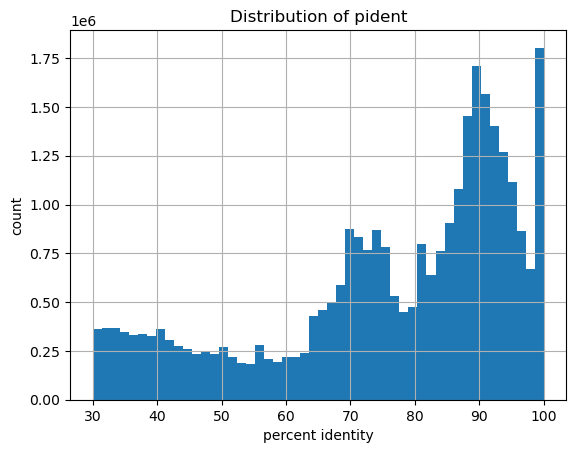

In [4]:
plt.figure()
df["pident"].hist(bins=50)
plt.xlabel("percent identity")
plt.ylabel("count")
plt.title("Distribution of pident")
plt.show()


アラインメント長

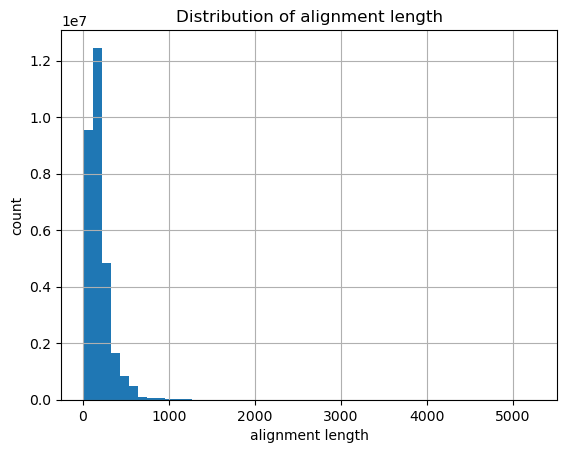

In [5]:
plt.figure()
df["alnlen"].hist(bins=50)
plt.xlabel("alignment length")
plt.ylabel("count")
plt.title("Distribution of alignment length")
plt.show()


e-value（log10）

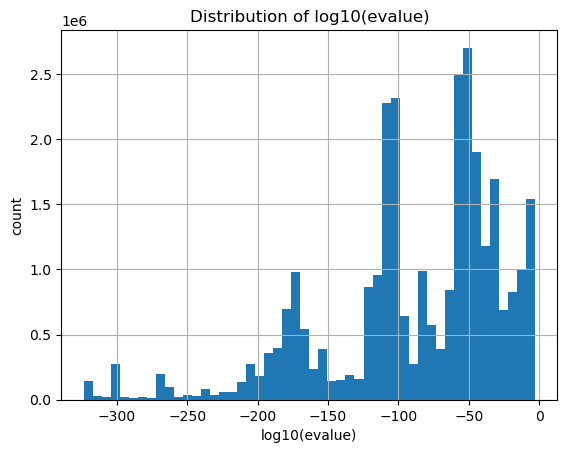

In [6]:
df["log10_evalue"] = df["evalue"].replace(0, 1e-300).map(lambda x: np.log10(x))

plt.figure()
df["log10_evalue"].hist(bins=50)
plt.xlabel("log10(evalue)")
plt.ylabel("count")
plt.title("Distribution of log10(evalue)")
plt.show()


4. UniProt 1つあたりのヒット数

In [7]:
hits_per_query = df["query"].value_counts()

hits_per_query.describe()


count    166019.000000
mean        181.650161
std         128.677394
min           1.000000
25%          29.000000
50%         270.000000
75%         300.000000
max         300.000000
Name: count, dtype: float64

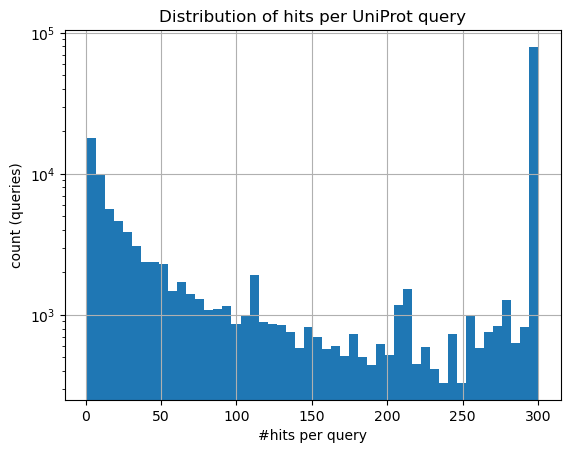

In [8]:
plt.figure()
hits_per_query.hist(bins=50)
plt.xlabel("#hits per query")
plt.ylabel("count (queries)")
plt.title("Distribution of hits per UniProt query")
plt.yscale("log")  # ログにすると見やすいこと多い
plt.show()


In [9]:
hits_per_query.head(10)

query
G1EQA7        300
A0A7S5C143    300
A0A7S5C1C2    300
A0A8S4QGC6    300
A0A7S5C1F8    300
A0A7S5C1J5    300
A0A7S5C1N1    300
A0A7S5C1R4    300
A0A7S5C1V4    300
A0A7S5C1Y8    300
Name: count, dtype: int64

5. 代表的なヒットを眺める

In [10]:
# pident 高い順の上位を見る
df.sort_values("pident", ascending=False).head(20)


,query,target,pident,alnlen,qstart,qend,tstart,tend,evalue,bits,log10_evalue
19480015,A0A1T4J2C1,5C08_F,100.0,276,25,300,1,276,5.518000e-191,596,-190.258218
21180232,G1EP91,3O3B_D,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
21180213,G1EP91,3BHB_A,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
21180214,G1EP91,5HHN_A,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
21180215,G1EP91,3GSN_H,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
...,...,...,...,...,...,...,...,...,...,...,...
1114216,A0A2S1IZV6,1EFX_A,100.0,273,1,273,2,274,9.831000e-189,584,-188.007402
21180226,G1EP91,3O3B_A,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
21180227,G1EP91,6NCA_C,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354
21180228,G1EP91,1EEZ_D,100.0,181,1,181,2,182,3.301000e-124,392,-123.481354


In [11]:
# evalue が良くて、alnlen もそこそこ長いもの
good = df[
    (df["pident"] >= 30) &
    (df["alnlen"] >= 50) &
    (df["evalue"] <= 1e-5)
].sort_values("pident", ascending=False)

good.head(20)


,query,target,pident,alnlen,qstart,qend,tstart,tend,evalue,bits,log10_evalue
14130032,A0A0G2R198,4P5M_F,100.0,87,1,87,29,115,5.687000e-56,190,-55.245117
10856494,A0A2I6PN85,8RNH_A,100.0,276,25,300,1,276,5.979000e-190,593,-189.223371
6436850,A0A4E9D3W4,8QFY_AAA,100.0,276,22,297,1,276,4.879000e-193,601,-192.311669
6436849,A0A4E9D3W4,7P49_C,100.0,276,22,297,1,276,4.879000e-193,601,-192.311669
6436848,A0A4E9D3W4,7BH8_A,100.0,276,22,297,1,276,4.879000e-193,601,-192.311669
...,...,...,...,...,...,...,...,...,...,...,...
10856790,A0A2I6Q7C8,5VZ5_A,100.0,280,25,304,1,280,2.828000e-192,599,-191.548521
10856791,A0A2I6Q7C8,5TXS_A,100.0,280,25,304,2,281,2.828000e-192,599,-191.548521
10856792,A0A2I6Q7C8,8ELG_A,100.0,278,25,302,1,278,4.814000e-191,596,-190.317494
10856793,A0A2I6Q7C8,8ELH_A,100.0,278,25,302,1,278,4.814000e-191,596,-190.317494
